<a href="https://colab.research.google.com/github/Fish210/Alliance-Optimization-Model/blob/main/Alliance_Optimization_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
##### Imports #####
!pip install catboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

##### Load in Input Data #####
#PATH = "/content/FTC_ML_Input_ActionsPlusScores_15Teams_FILLED_ebh3.xlsx"
PATH = "/content/FTC_ALLIANCE_ML_MODEL_TRAINING_LT2026.xlsx"
df = pd.read_excel(PATH, sheet_name="team_match_actions")
df = df[df["team"].notna()].copy()

count_cols=[
    "auto_leave", "auto_artifact_cl_count", "auto_artifact_overflow_count", "auto_motif_match_count",
    "tele_artifact_cl_count", "tele_artifact_overflow_count","tele_motif_match_count", "tele_depot_count"
]
for c in count_cols:
  df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype(int)
##### Attatch scores to actions #####
df["auto_points"] = (
    3*df["auto_leave"]
    + 3*df["auto_artifact_cl_count"]
    + 1*df["auto_artifact_overflow_count"]
    + 2*df["auto_motif_match_count"]
)
df["tele_points"] = (
    3*df["tele_artifact_cl_count"]
    + 1*df["tele_artifact_overflow_count"]
    + 2*df["tele_motif_match_count"]
    + 1*df["tele_depot_count"]
)



/usr/local/lib/python3.12/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


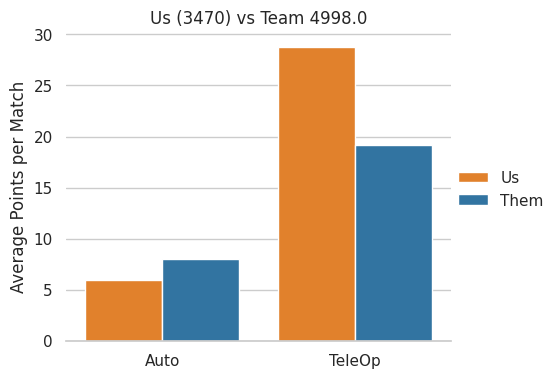

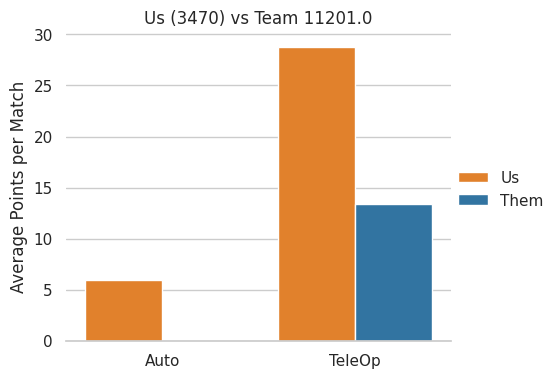

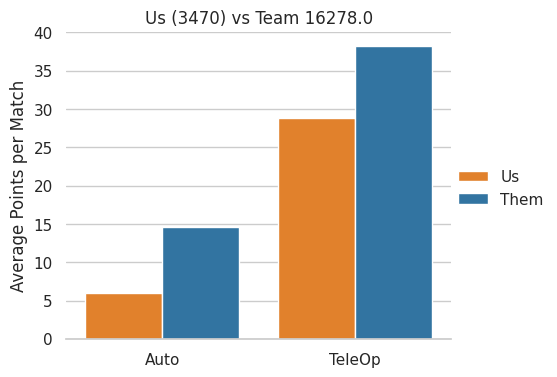

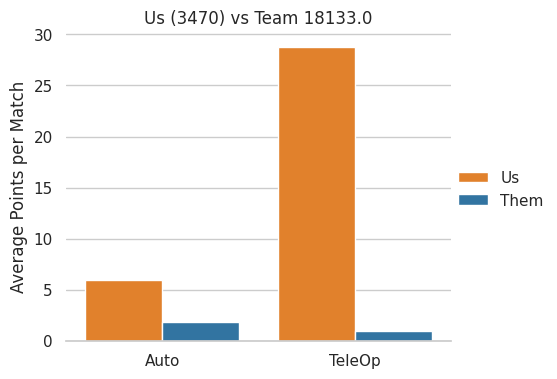

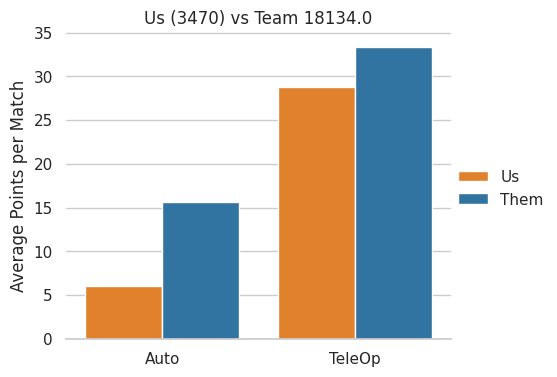

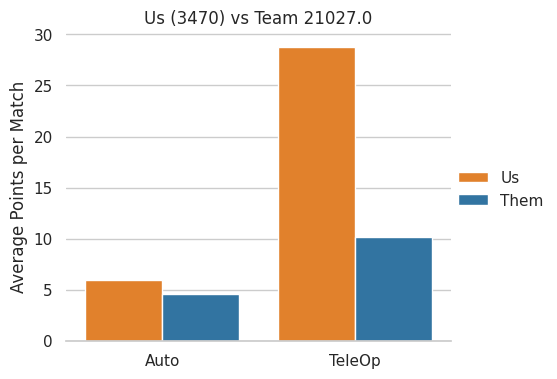

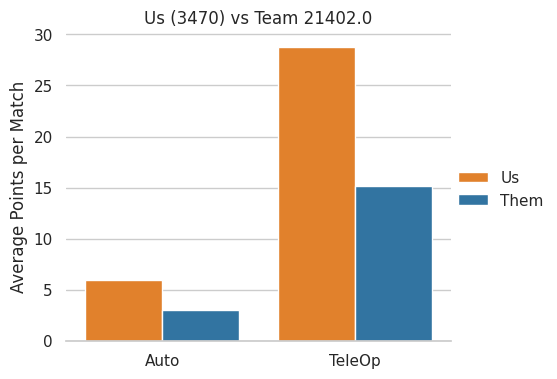

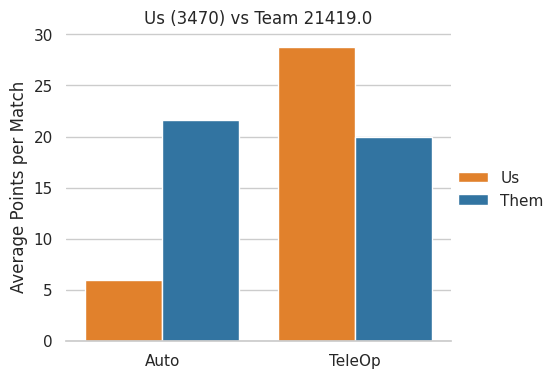

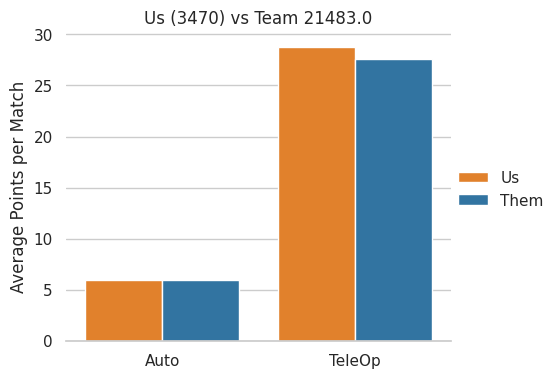

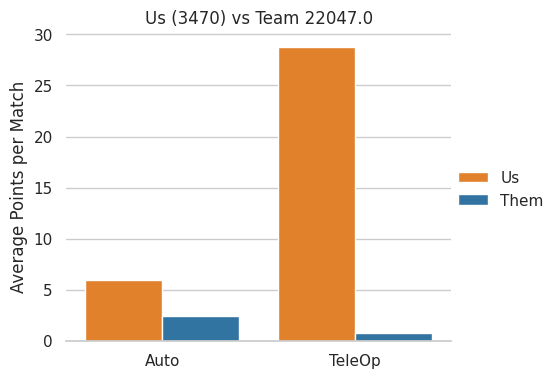

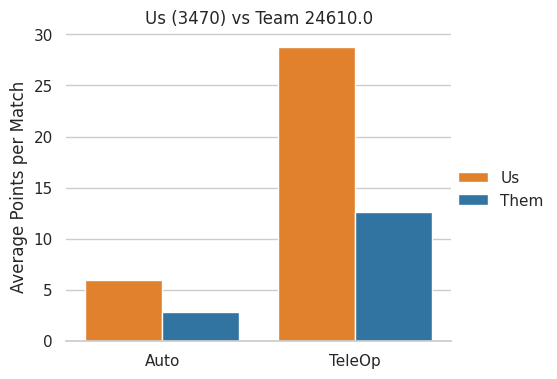

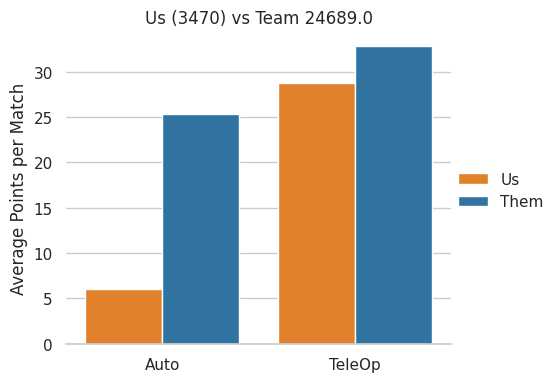

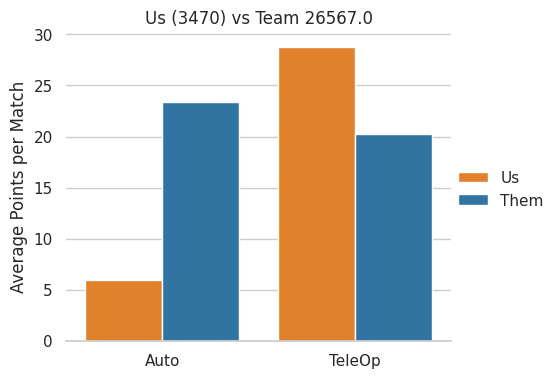

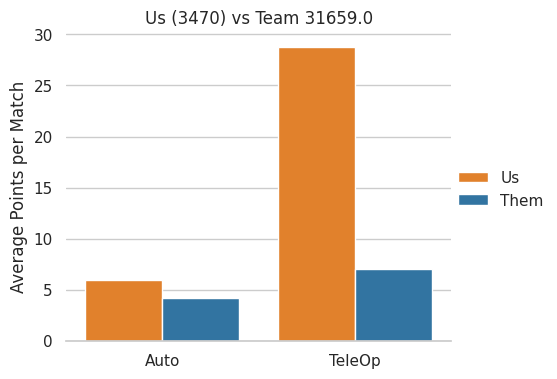

In [11]:
team_summary = (
    df.groupby("team")[["auto_points", "tele_points"]]
      .mean()
      .reset_index()
)

US_TEAM = 3470

# --- Candidate teams ---
CANDIDATE_TEAM = team_summary["team"].unique()
CANDIDATE_TEAM = [t for t in CANDIDATE_TEAM if t != US_TEAM]

# --- Cache our team once ---
us = team_summary[team_summary["team"] == US_TEAM].iloc[0]

sns.set_theme(style="whitegrid")

# --- Loop through candidates ---
for team in CANDIDATE_TEAM:
    them = team_summary[team_summary["team"] == team].iloc[0]

    df_plot = pd.DataFrame({
        "Period": ["Auto", "Auto", "TeleOp", "TeleOp"],
        "Points": [
            us["auto_points"], them["auto_points"],
            us["tele_points"], them["tele_points"]
        ],
        "Team": ["Us", "Them", "Us", "Them"]
    })

    g = sns.catplot(
        data=df_plot,
        kind="bar",
        x="Period",
        y="Points",
        hue="Team",
        palette=["tab:orange", "tab:blue"],
        height=4,
        aspect=1.2
    )

    g.set_axis_labels("", "Average Points per Match")
    g.legend.set_title("")
    g.despine(left=True)
    plt.title(f"Us (3470) vs Team {team}")
    plt.show()


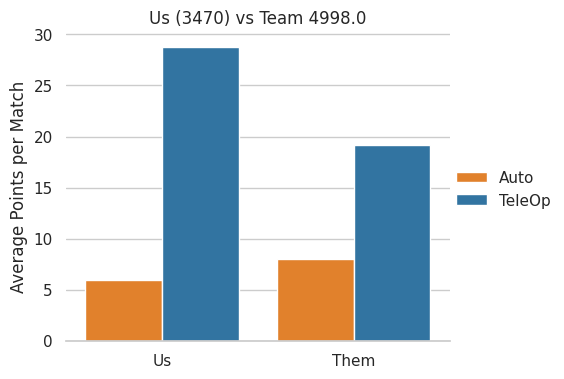

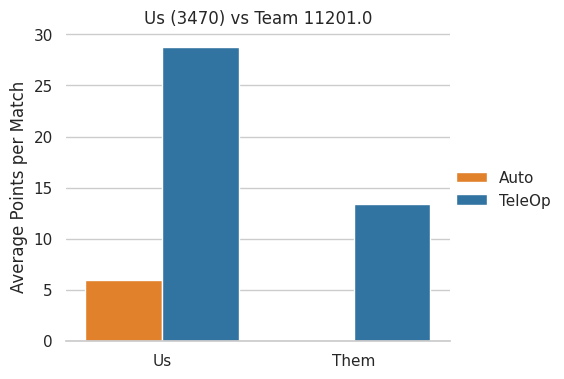

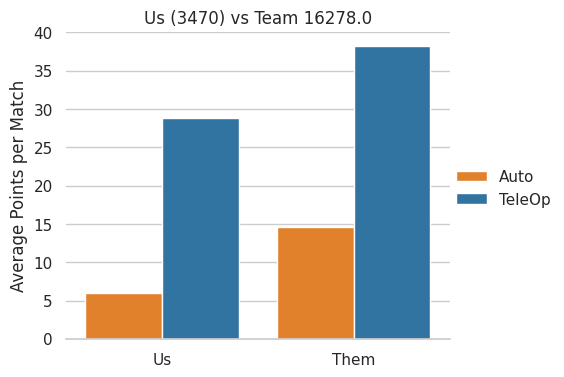

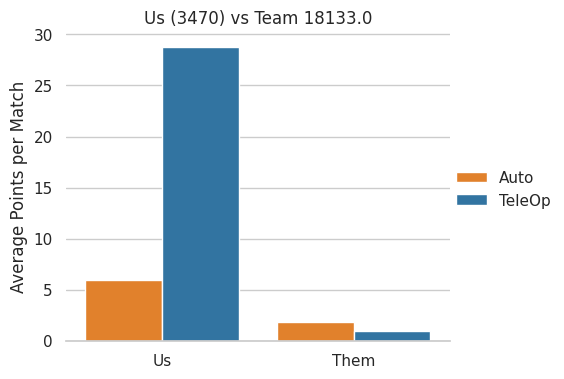

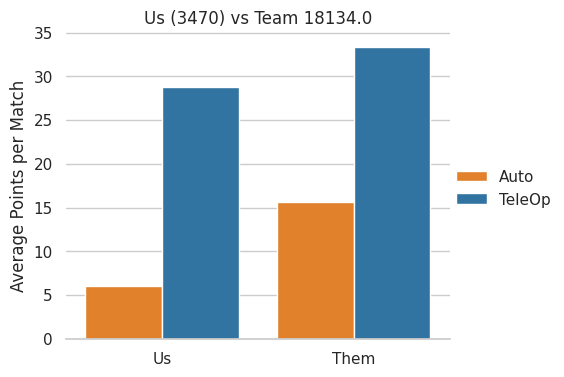

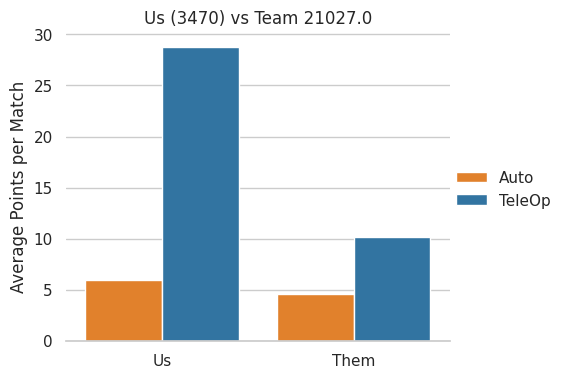

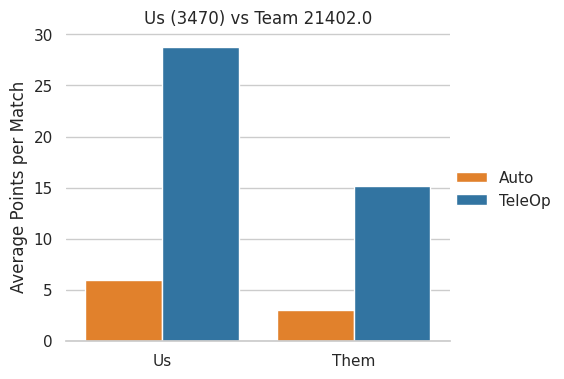

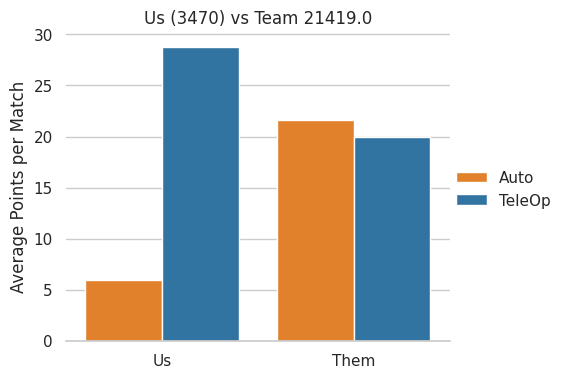

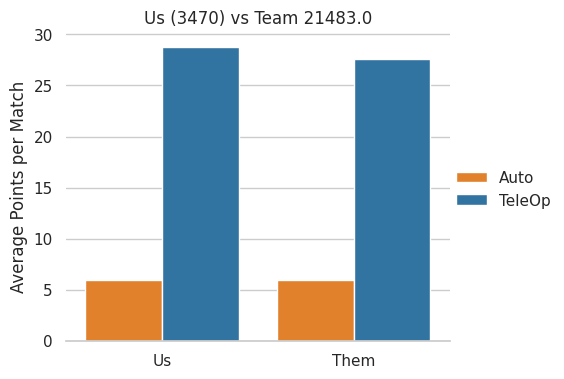

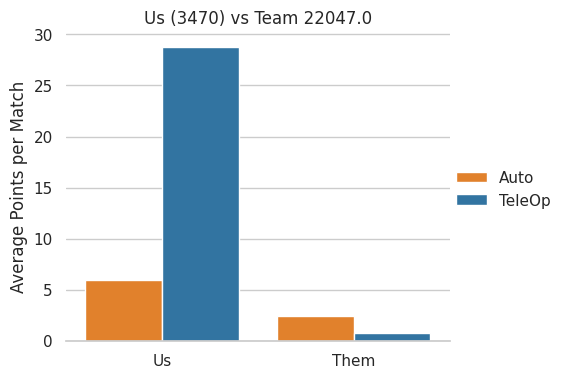

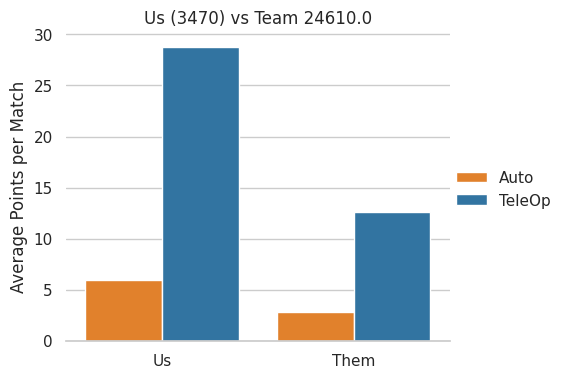

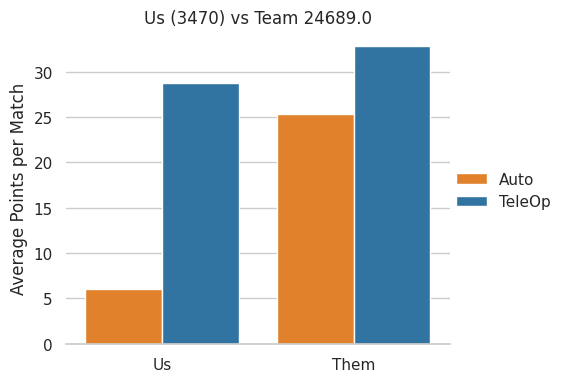

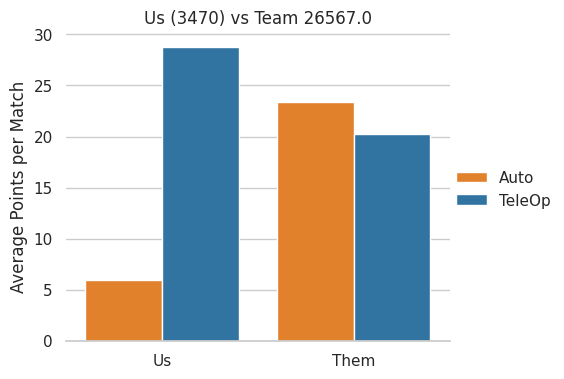

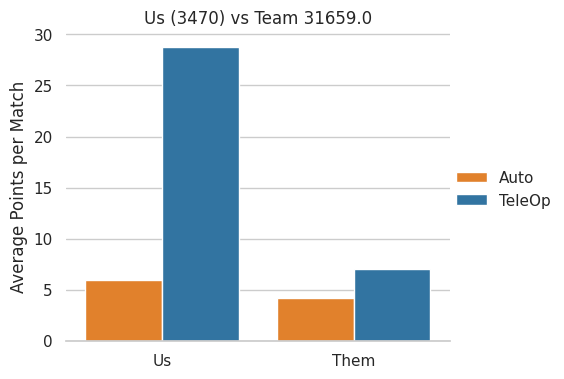

In [13]:
sns.set_theme(style="whitegrid")

# Cache our team once
us = team_summary[team_summary["team"] == US_TEAM].iloc[0]

for team in CANDIDATE_TEAM:
    them = team_summary[team_summary["team"] == team].iloc[0]

    df_plot = pd.DataFrame({
        "Team": ["Us", "Us", "Them", "Them"],
        "Period": ["Auto", "TeleOp", "Auto", "TeleOp"],
        "Points": [
            us["auto_points"], us["tele_points"],
            them["auto_points"], them["tele_points"]
        ]
    })

    g = sns.catplot(
        data=df_plot,
        kind="bar",
        x="Team",
        y="Points",
        hue="Period",
        palette=["tab:orange", "tab:blue"],
        height=4,
        aspect=1.2
    )

    g.set_axis_labels("", "Average Points per Match")
    g.legend.set_title("")
    g.despine(left=True)
    plt.title(f"Us (3470) vs Team {team}")
    plt.show()
